<a href='https://honglab.ai'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="100%" height="100%"/></p></a>

<center><em>Content Copyright by HongLab, Inc.</em></center>

# 컴퓨터 그래픽스 핵심 정리

[안내] 강의 노트의 코드들은 이해를 돕기 위한 학습/가시화 용도입니다.

## 차례
1.  **동차 좌표계와 변환**
2.  **좌표계와 투영**
3.  **래스터화 - 삼각형**
4.  **래스터화 - 타원체**

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from scipy.spatial.transform import Rotation as R

## 1. 동차 좌표계와 애파인 변환

#### 동차 좌표계(homogeneous coordinates)

*   점(point): $(x, y, z, 1)$
*   벡터(vector): $(x, y, z, 0)$

#### 애파인 변환(affine transformation)
$$
\begin{bmatrix}
r_{00} & r_{01} & r_{02} & t_x \\
r_{10} & r_{11} & r_{12} & t_y \\
r_{20} & r_{21} & r_{22} & t_z \\
0 & 0 & 0 & 1
\end{bmatrix}
$$
왼쪽 위 3x3은 회전/크기 조절(Rotation/Scale), 오른쪽 열(column)은 이동(Translation)입니다.

점(point)은 이동의 영향을 받습니다:
$$
\begin{bmatrix}
1 & 0 & 0 & 5 \\
0 & 1 & 0 & 3 \\
0 & 0 & 1 & 2 \\
0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
x \\
y \\
z \\
1
\end{bmatrix}
=
\begin{bmatrix}
x + 5 \\
y + 3 \\
z + 2 \\
1
\end{bmatrix}
$$

벡터(vector)는 이동의 영향을 받지 **않습니다**:
$$
\begin{bmatrix}
1 & 0 & 0 & 5 \\
0 & 1 & 0 & 3 \\
0 & 0 & 1 & 2 \\
0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
x \\
y \\
z \\
0
\end{bmatrix}
=
\begin{bmatrix}
x \\
y \\
z \\
0
\end{bmatrix}
$$

#### 참고: 열 벡터(column vector) vs 행 벡터(row vector) 표기법

이 노트에서는 사용하고 있는 것은 **열 벡터(column vector)** 표기법 입니다: $\mathbf{M} \cdot \mathbf{v}$
$$
\begin{bmatrix}
1 & 0 & 0 & 5 \\
0 & 1 & 0 & 3 \\
0 & 0 & 1 & 2 \\
0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
x \\
y \\
z \\
1
\end{bmatrix}
=
\begin{bmatrix}
x + 5 \\
y + 3 \\
z + 2 \\
1
\end{bmatrix}
$$

**행 벡터(row vector)** 표기법에서는 벡터를 행으로 쓰고 전치(transpose) 행렬을 사용합니다: $\mathbf{v}^T \cdot \mathbf{M}^T$
$$
\begin{bmatrix}
x & y & z & 1
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
5 & 3 & 2 & 1
\end{bmatrix}
=
\begin{bmatrix}
x + 5 & y + 3 & z + 2 & 1
\end{bmatrix}
$$

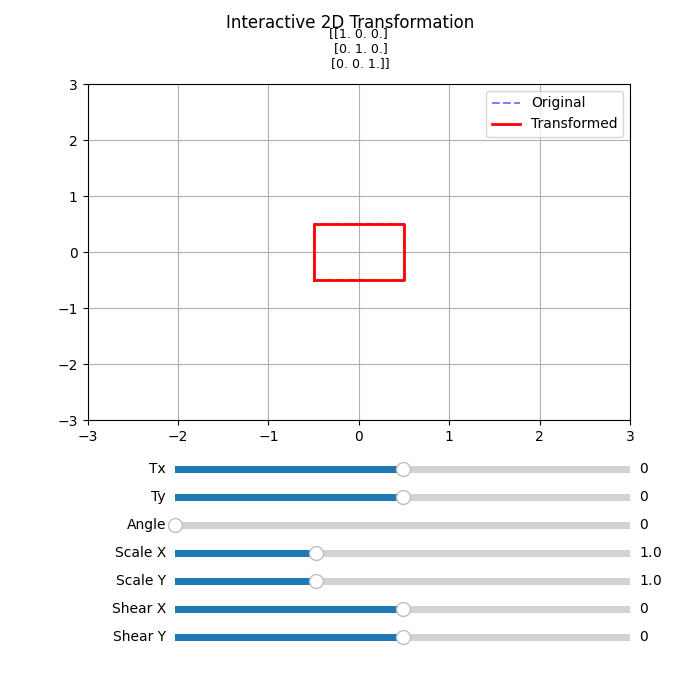

In [ ]:
%matplotlib ipympl

# Create a square centered at origin
points = np.array([
    [-0.5, -0.5, 1],
    [ 0.5, -0.5, 1],
    [ 0.5,  0.5, 1],
    [-0.5,  0.5, 1],
    [-0.5, -0.5, 1] # Close the loop
]).T # 3x5 matrix

# Initial parameters
tx, ty, angle_deg = 0.0, 0.0, 0.0
scale_x, scale_y = 1.0, 1.0
shear_x, shear_y = 0.0, 0.0

fig = plt.figure(figsize=(7, 7))
fig.suptitle("Interactive 2D Transformation")
plt.subplots_adjust(bottom=0.4)

ax = plt.axes()
line_orig, = ax.plot(points[0, :], points[1, :], 'b--', label='Original', alpha=0.5)
line_trans, = ax.plot(points[0, :], points[1, :], 'r-', label='Transformed', linewidth=2)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.grid(True)
ax.legend()
identity = np.eye(3)
title_text = ax.text(0.5, 1.05, f"{np.round(identity, 2)}", transform=ax.transAxes, ha='center', fontsize=9)

# Create sliders
slider_tx = Slider(plt.axes([0.25, 0.32, 0.65, 0.02]), "Tx", -3, 3, valinit=tx)
slider_ty = Slider(plt.axes([0.25, 0.28, 0.65, 0.02]), "Ty", -3, 3, valinit=ty)
slider_angle = Slider(plt.axes([0.25, 0.24, 0.65, 0.02]), "Angle", 0, 360, valinit=angle_deg)
slider_sx = Slider(plt.axes([0.25, 0.20, 0.65, 0.02]), "Scale X", 0.1, 3, valinit=scale_x)
slider_sy = Slider(plt.axes([0.25, 0.16, 0.65, 0.02]), "Scale Y", 0.1, 3, valinit=scale_y)
slider_shx = Slider(plt.axes([0.25, 0.12, 0.65, 0.02]), "Shear X", -2, 2, valinit=shear_x)
slider_shy = Slider(plt.axes([0.25, 0.08, 0.65, 0.02]), "Shear Y", -2, 2, valinit=shear_y)

def update(val):
    tx = slider_tx.val
    ty = slider_ty.val
    angle_deg = slider_angle.val
    scale_x = slider_sx.val
    scale_y = slider_sy.val
    shear_x = slider_shx.val
    shear_y = slider_shy.val
    
    theta = np.radians(angle_deg)
    c, s = np.cos(theta), np.sin(theta)
    
    # Transformation Matrices
    S = np.array([
        [scale_x, 0, 0], 
        [0, scale_y, 0], 
        [0, 0, 1]])
    
    Sh = np.array([
        [1, shear_x, 0], 
        [shear_y, 1, 0], 
        [0, 0, 1]])
    
    R = np.array([
        [c, -s, 0], 
        [s, c, 0], 
        [0, 0, 1]])
    
    T = np.array([
        [1, 0, tx], 
        [0, 1, ty], 
        [0, 0, 1]])
    
    # Combined: T * R * Sh * S (Order matters!)
    M = TODO
    transformed_points = TODO
    
    line_trans.set_data(transformed_points[0, :], transformed_points[1, :])
    
    # Check if at default values (identity matrix)
    is_identity = (abs(tx) < 0.01 and abs(ty) < 0.01 and abs(angle_deg) < 0.1 and 
                   abs(scale_x - 1.0) < 0.01 and abs(scale_y - 1.0) < 0.01 and 
                   abs(shear_x) < 0.01 and abs(shear_y) < 0.01)
    
    if is_identity:
        title_text.set_text(f"{np.round(np.eye(3), 2)}")
    else:
        title_text.set_text(f"{np.round(M, 2)}")
    
    fig.canvas.draw_idle()

slider_tx.on_changed(update)
slider_ty.on_changed(update)
slider_angle.on_changed(update)
slider_sx.on_changed(update)
slider_sy.on_changed(update)
slider_shx.on_changed(update)
slider_shy.on_changed(update)

plt.show()

## 2. 좌표계와 투영

컴퓨터 그래픽스에서는 이해와 구현을 쉽게하기 위해서 여러가지의 "공간"이라는 개념을 사용합니다.

### 좌표계
1.  **월드 공간(World Space)**: 모든 객체가 존재하는 전역 좌표계입니다.
2.  **카메라(뷰) 공간(Camera/View Space)**: 카메라에서 바라본 세계입니다. 카메라는 (0,0,0)에 위치하며 -Z 방향을 바라봅니다.
3.  **클립 공간(Clip Space)**: 투영 행렬을 적용한 후의 좌표계입니다.
4.  **스크린(NDC) 공간(Screen/NDC Space)**: 원근 나누기(perspective divide) 후 스크린에 투영된 2D 좌표계입니다.

### 뷰 변환 (월드 → 카메라)
월드 공간의 점을 카메라 공간으로 변환하려면 뷰 행렬(View Matrix)을 적용합니다:
$$\mathbf{p}_{\text{camera}} = \mathbf{V} \cdot \mathbf{p}_{\text{world}}$$

뷰 행렬은 카메라의 위치와 방향으로부터 구성됩니다:
$$\mathbf{V} = \left( \mathbf{T}\cdot\mathbf{R} \right)^{-1} = \mathbf{R}^{-1} \cdot \mathbf{T}^{-1}$$

여기서 $\mathbf{R}$은 카메라의 회전, $\mathbf{T}$는 카메라의 이동입니다. 이는 실질적으로 세계를 "이동"시켜 카메라가 원점에서 -Z축 방향을 바라보도록 합니다.

### 투영 행렬
투영 행렬(Projection Matrix)은 3D 카메라 좌표를 클립 공간(그리고 최종적으로 스크린 공간)으로 변환합니다. 여기서 3D 장면이 2D 스크린에 투영됩니다.

#### 원근 투영(Perspective Projection)
*   인간의 눈과 카메라를 모방합니다.
*   **단축법(Foreshortening)**: 멀리 있는 물체가 더 작게 보입니다.
*   **시야각(Field of View, FOV)**, 종횡비(Aspect Ratio), 근거리 및 원거리 클리핑 평면으로 정의됩니다.
*   $w$ 성분은 $-z$가 되어 나중에 "원근 나누기"를 발생시킵니다.

원근 투영 행렬은 다음과 같습니다 ([유도과정참고](https://www.songho.ca/opengl/gl_projectionmatrix.html)):
$$
\mathbf{P} = \begin{bmatrix}
\frac{f}{a} & 0 & 0 & 0 \\
0 & f & 0 & 0 \\
0 & 0 & \frac{n+f}{n-f} & \frac{2nf}{n-f} \\
0 & 0 & -1 & 0
\end{bmatrix}
$$

여기서 $f = \cot(\text{FOV}/2)$, $a$는 종횡비, $n$은 근거리 평면, $f$는 원거리 평면까지의 거리입니다.

투영 행렬을 카메라 공간의 점에 적용하면:
$$
\mathbf{P} \cdot \begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix} = 
\begin{bmatrix}
\frac{f}{a} & 0 & 0 & 0 \\
0 & f & 0 & 0 \\
0 & 0 & \frac{n+f}{n-f} & \frac{2nf}{n-f} \\
0 & 0 & -1 & 0
\end{bmatrix}
\begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix}
=
\begin{bmatrix}
\frac{fx}{a} \\
fy \\
\frac{(n+f)z + 2nf}{n-f} \\
-z
\end{bmatrix}
$$

주목할 점은 $w$ 성분이 $-z$가 된다는 것입니다 (카메라 공간의 깊이).

#### 원근 나누기

투영 행렬을 적용한 후 각 점은 클립 공간에서 $(x, y, z, w)$가 됩니다. 마지막 단계는 원근 나누기(perspective divide)입니다:
$$\mathbf{p}_{\text{NDC}} = \left(\frac{x}{w}, \frac{y}{w}, \frac{z}{w}\right)$$

$w$로 나누는 이 과정(카메라 공간에서 $-z$와 같음)이 단축 효과를 만듭니다: $z$가 큰(더 멀리 있는) 물체는 더 큰 수로 나누어져 화면에서 더 작게 보입니다.

#### NDC (정규화된 장치 좌표)
원근 나누기 후 가시적인 점들은 $[-1, 1]^3$ 큐브 안에 위치합니다:
*   이 범위 밖의 점들은 **클리핑**(렌더링되지 않음)됩니다
*   $z$ 성분은 은면 제거를 위한 깊이를 결정합니다
*   $(x, y)$는 스크린 좌표에 직접 매핑됩니다

### 절두체(Frustum)
뷰 절두체(view frustum)는 카메라에 가시적인 3D 영역입니다:
*   근거리 평면(near plane), 원거리 평면(far plane), 시야각(FOV)으로 결정되는 꼭지가 잘린 피라미드 형태

다음 예제는 전체 파이프라인을 시각화합니다: 월드 공간 → 카메라 공간 → 투영 → 스크린 공간.

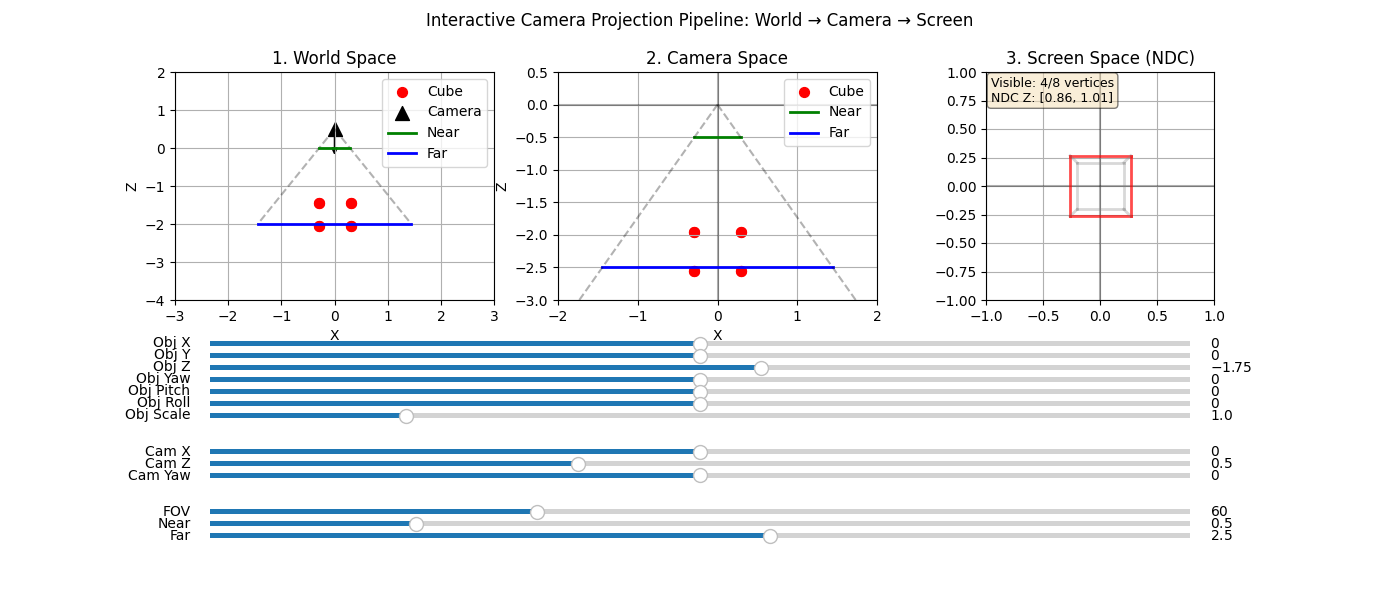

In [ ]:
%matplotlib ipympl

# Define unit cube centered at origin
unit_cube = np.array([
    [-0.3, -0.3, -0.3], [0.3, -0.3, -0.3], [0.3, 0.3, -0.3], [-0.3, 0.3, -0.3],
    [-0.3, -0.3, 0.3], [0.3, -0.3, 0.3], [0.3, 0.3, 0.3], [-0.3, 0.3, 0.3]
]).T

# Initial object transformation parameters
obj_x, obj_y, obj_z = 0.0, 0.0, -1.75
obj_yaw, obj_pitch, obj_roll = 0.0, 0.0, 0.0
obj_scale = 1.0

# Initial camera and projection parameters
cam_x, cam_z, cam_yaw = 0.0, 0.5, 0.0
fov, near, far = 60.0, 0.5, 2.5

fig = plt.figure(figsize=(14, 6))
fig.suptitle("Interactive Camera Projection Pipeline: World → Camera → Screen")
plt.subplots_adjust(bottom=0.50)

# Subplot 1: World Space (Top-Down View)
ax1 = fig.add_subplot(131)
ax1.set_title("1. World Space")
ax1.set_xlim(-3, 3); ax1.set_ylim(-4, 2)
ax1.set_xlabel("X"); ax1.set_ylabel("Z")
ax1.grid(True)

cube_world_scatter = ax1.scatter([], [], c='r', s=50, label='Cube')
cam_scatter = ax1.scatter(0, 0, c='k', s=100, marker='^', label='Camera')
cam_arrow = ax1.arrow(0, 0, 0, -0.5, head_width=0.1, fc='k', ec='k')
fov_left_line, = ax1.plot([0, 0], [0, 0], 'k--', alpha=0.3)
fov_right_line, = ax1.plot([0, 0], [0, 0], 'k--', alpha=0.3)
near_line_world, = ax1.plot([], [], 'g-', linewidth=2, label='Near')
far_line_world, = ax1.plot([], [], 'b-', linewidth=2, label='Far')
ax1.legend()

# Subplot 2: Camera Space (Top-Down View)
ax2 = fig.add_subplot(132)
ax2.set_title("2. Camera Space")
ax2.set_xlim(-2, 2); ax2.set_ylim(-3, 0.5)
ax2.set_xlabel("X"); ax2.set_ylabel("Z")
ax2.grid(True)
ax2.axhline(0, color='k', alpha=0.3)
ax2.axvline(0, color='k', alpha=0.3)

cube_cam_scatter = ax2.scatter([], [], c='r', s=50, label='Cube')
near_line, = ax2.plot([], [], 'g-', linewidth=2, label='Near')
far_line, = ax2.plot([], [], 'b-', linewidth=2, label='Far')
fov_cam_left, = ax2.plot([0, 0], [0, 0], 'k--', alpha=0.3)
fov_cam_right, = ax2.plot([0, 0], [0, 0], 'k--', alpha=0.3)
ax2.legend()

# Subplot 3: Screen Space (NDC)
ax3 = fig.add_subplot(133)
ax3.set_title("3. Screen Space (NDC)")
ax3.set_xlim(-1, 1); ax3.set_ylim(-1, 1)
ax3.set_aspect('equal')
ax3.grid(True)
ax3.axhline(0, color='k', alpha=0.3)
ax3.axvline(0, color='k', alpha=0.3)

ndc_lines = [ax3.plot([], [], 'r-', linewidth=2, alpha=0.7)[0] for _ in range(12)]
ndc_text = ax3.text(0.02, 0.98, '', transform=ax3.transAxes, fontsize=9,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Create sliders - Object controls
slider_ox = Slider(plt.axes([0.15, 0.42, 0.7, 0.015]), "Obj X", -3, 3, valinit=obj_x)
slider_oy = Slider(plt.axes([0.15, 0.40, 0.7, 0.015]), "Obj Y", -2, 2, valinit=obj_y)
slider_oz = Slider(plt.axes([0.15, 0.38, 0.7, 0.015]), "Obj Z", -4, 0, valinit=obj_z)
slider_oyaw = Slider(plt.axes([0.15, 0.36, 0.7, 0.015]), "Obj Yaw", -180, 180, valinit=obj_yaw)
slider_opitch = Slider(plt.axes([0.15, 0.34, 0.7, 0.015]), "Obj Pitch", -90, 90, valinit=obj_pitch)
slider_oroll = Slider(plt.axes([0.15, 0.32, 0.7, 0.015]), "Obj Roll", -180, 180, valinit=obj_roll)
slider_oscale = Slider(plt.axes([0.15, 0.30, 0.7, 0.015]), "Obj Scale", 0.5, 3.0, valinit=obj_scale)

# Camera controls
slider_cx = Slider(plt.axes([0.15, 0.24, 0.7, 0.015]), "Cam X", -3, 3, valinit=cam_x)
slider_cz = Slider(plt.axes([0.15, 0.22, 0.7, 0.015]), "Cam Z", -1, 3, valinit=cam_z)
slider_cyaw = Slider(plt.axes([0.15, 0.20, 0.7, 0.015]), "Cam Yaw", -45, 45, valinit=cam_yaw)

# Projection controls
slider_fov = Slider(plt.axes([0.15, 0.14, 0.7, 0.015]), "FOV", 30, 120, valinit=fov)
slider_near = Slider(plt.axes([0.15, 0.12, 0.7, 0.015]), "Near", 0.1, 2.0, valinit=near)
slider_far = Slider(plt.axes([0.15, 0.10, 0.7, 0.015]), "Far", 0.5, 4.0, valinit=far)

def update(val):
    global cam_arrow
    
    # Get object transformation parameters
    obj_x = slider_ox.val
    obj_y = slider_oy.val
    obj_z = slider_oz.val
    obj_yaw = slider_oyaw.val
    obj_pitch = slider_opitch.val
    obj_roll = slider_oroll.val
    obj_scale = slider_oscale.val
    
    # Get camera parameters
    cam_x = slider_cx.val
    cam_z = slider_cz.val
    cam_yaw = slider_cyaw.val
    fov = slider_fov.val
    near = slider_near.val
    far = slider_far.val
    
    # Apply object transformation (Scale → Rotate → Translate)
    obj_rot = R.from_euler('zyx', [obj_yaw, obj_pitch, obj_roll], degrees=True)
    cube_pts_world = obj_rot.apply(unit_cube.T * obj_scale).T + np.array([[obj_x], [obj_y], [obj_z]])
    
    # Camera transformation
    cam_pos = np.array([cam_x, 0, cam_z])
    cam_rot = R.from_euler('y', cam_yaw, degrees=True)
    
    # Compute View Matrix (World → Camera)
    R_view = cam_rot.inv()
    t_view = -R_view.apply(cam_pos)
    cube_pts_cam = R_view.apply(cube_pts_world.T).T + t_view[:, np.newaxis]
    
    # Perspective Projection Matrix (Camera → Clip → NDC)
    aspect = 1.0
    cube_pts_h = np.vstack([cube_pts_cam, np.ones((1, 8))])
    f = 1.0 / np.tan(np.radians(fov) / 2)
    P = np.zeros((4, 4))
    P[0, 0] = TODO
    P[1, 1] = TODO
    P[2, 2] = TODO
    P[2, 3] = TODO
    P[3, 2] = -1.0
    
    projected_h = P @ cube_pts_h
    w_safe = np.where(np.abs(projected_h[3, :]) > 1e-6, projected_h[3, :], 1.0)
    ndc = projected_h[:3, :] / w_safe
    
    # Update World Space view
    cube_world_scatter.set_offsets(np.c_[cube_pts_world[0, :], cube_pts_world[2, :]])
    cam_scatter.set_offsets([cam_pos[0], cam_pos[2]])
    cam_arrow.remove()
    cam_dir = cam_rot.apply(np.array([0, 0, -1]))
    cam_arrow = ax1.arrow(cam_pos[0], cam_pos[2], cam_dir[0]*0.5, cam_dir[2]*0.5,
                          head_width=0.1, fc='k', ec='k')
    
    # FOV visualization in world space
    fov_half = np.radians(fov) / 2
    fov_left_world = cam_rot.apply(np.array([-np.tan(fov_half), 0, -1]))
    fov_right_world = cam_rot.apply(np.array([np.tan(fov_half), 0, -1]))
    fov_dist = 2.5
    fov_left_line.set_data([cam_pos[0], cam_pos[0] + fov_left_world[0]*fov_dist],
                           [cam_pos[2], cam_pos[2] + fov_left_world[2]*fov_dist])
    fov_right_line.set_data([cam_pos[0], cam_pos[0] + fov_right_world[0]*fov_dist],
                            [cam_pos[2], cam_pos[2] + fov_right_world[2]*fov_dist])
    
    # Near and far planes in world space
    near_world_z = cam_pos[2] + cam_dir[2] * near
    far_world_z = cam_pos[2] + cam_dir[2] * far
    near_width_world = np.tan(fov_half) * near
    far_width_world = np.tan(fov_half) * far
    
    # Transform plane corners to world space
    near_left_world = cam_rot.apply(np.array([-near_width_world, 0, -near])) + cam_pos
    near_right_world = cam_rot.apply(np.array([near_width_world, 0, -near])) + cam_pos
    far_left_world = cam_rot.apply(np.array([-far_width_world, 0, -far])) + cam_pos
    far_right_world = cam_rot.apply(np.array([far_width_world, 0, -far])) + cam_pos
    
    near_line_world.set_data([near_left_world[0], near_right_world[0]], 
                             [near_left_world[2], near_right_world[2]])
    far_line_world.set_data([far_left_world[0], far_right_world[0]], 
                            [far_left_world[2], far_right_world[2]])
    
    # Update Camera Space view
    cube_cam_scatter.set_offsets(np.c_[cube_pts_cam[0, :], cube_pts_cam[2, :]])
    
    # Near and far planes in camera space
    near_z = -near
    far_z = -far
    near_width = np.tan(np.radians(fov)/2) * near
    far_width = np.tan(np.radians(fov)/2) * far
    near_line.set_data([-near_width, near_width], [near_z, near_z])
    far_line.set_data([-far_width, far_width], [far_z, far_z])
    
    # FOV lines in camera space
    max_z = -3
    x_spread = np.tan(np.radians(fov)/2) * abs(max_z)
    fov_cam_left.set_data([0, -x_spread], [0, max_z])
    fov_cam_right.set_data([0, x_spread], [0, max_z])
    
    # Update Screen Space (NDC) view
    z_ndc = ndc[2, :]
    visible = (z_ndc >= -1.0) & (z_ndc <= 1.0)
    
    # Draw cube edges in NDC
    edges = [
        (0,1), (1,2), (2,3), (3,0),  # front face
        (4,5), (5,6), (6,7), (7,4),  # back face
        (0,4), (1,5), (2,6), (3,7)   # connecting edges
    ]
    
    for i, (start, end) in enumerate(edges):
        if visible[start] and visible[end]:
            ndc_lines[i].set_data([ndc[0, start], ndc[0, end]], [ndc[1, start], ndc[1, end]])
            ndc_lines[i].set_color('r')
            ndc_lines[i].set_alpha(0.7)
        else:
            ndc_lines[i].set_data([ndc[0, start], ndc[0, end]], [ndc[1, start], ndc[1, end]])
            ndc_lines[i].set_color('gray')
            ndc_lines[i].set_alpha(0.3)
    
    z_min, z_max = z_ndc.min(), z_ndc.max()
    visible_count = np.sum(visible)
    ndc_text.set_text(f"Visible: {visible_count}/8 vertices\nNDC Z: [{z_min:.2f}, {z_max:.2f}]")
    
    fig.canvas.draw_idle()

# Connect object sliders
slider_ox.on_changed(update)
slider_oy.on_changed(update)
slider_oz.on_changed(update)
slider_oyaw.on_changed(update)
slider_opitch.on_changed(update)
slider_oroll.on_changed(update)
slider_oscale.on_changed(update)

# Connect camera sliders
slider_cx.on_changed(update)
slider_cz.on_changed(update)
slider_cyaw.on_changed(update)

# Connect projection sliders
slider_fov.on_changed(update)
slider_near.on_changed(update)
slider_far.on_changed(update)

# Initial draw
update(None)

plt.show()

## 3. 래스터화 - 삼각형

래스터화(Rasterization)는 모니터에 물체를 그릴때 그 물체가 모니터의 어떤 픽셀에 대응되는지를 찾는 문제입니다.

*   빠르고 효율적이며, 실시간 그래픽스의 표준입니다
*   3D 삼각형을 2D 스크린 공간에 투영합니다
*   수학적 테스트를 사용하여 픽셀 포함 여부를 결정합니다

### 무게중심 좌표
삼각형을 래스터화하려면 픽셀 중심 $\mathbf{p}$가 삼각형 내부(꼭짓점 $\mathbf{a}$, $\mathbf{b}$, $\mathbf{c}$)에 있는지 확인합니다. $\mathbf{p}$를 가중합으로 표현합니다:
$$ \mathbf{p} = u\mathbf{a} + v\mathbf{b} + w\mathbf{c} $$
$u, v, w \ge 0$ 이고 $u+v+w=1$이면 점은 내부에 있습니다.

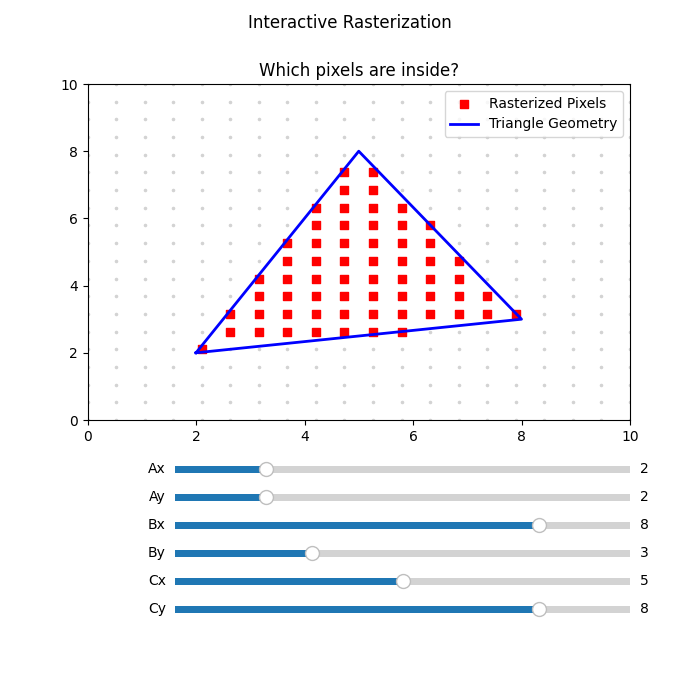

In [ ]:
%matplotlib ipympl

# Setup grid
grid_size = 20
x = np.linspace(0, 10, grid_size)
y = np.linspace(0, 10, grid_size)
X, Y = np.meshgrid(x, y)

# Initial triangle vertices
ax, ay, bx, by, cx, cy = 2.0, 2.0, 8.0, 3.0, 5.0, 8.0

fig = plt.figure(figsize=(7, 7))
fig.suptitle("Interactive Rasterization")
plt.subplots_adjust(bottom=0.4)

ax_plot = plt.axes()
ax_plot.set_xlim(0, 10)
ax_plot.set_ylim(0, 10)
ax_plot.set_title("Which pixels are inside?")

grid_outside = ax_plot.scatter([], [], c='lightgray', s=10, marker='.')
grid_inside = ax_plot.scatter([], [], c='red', s=30, marker='s', label='Rasterized Pixels')
triangle_line, = ax_plot.plot([], [], 'b-', linewidth=2, label='Triangle Geometry')
ax_plot.legend(loc='upper right')

# Function to compute barycentric coords
def get_barycentric(p, a, b, c):
    v0 = b - a
    v1 = c - a
    v2 = p - a
    d00 = np.dot(v0, v0)
    d01 = np.dot(v0, v1)
    d11 = np.dot(v1, v1)
    d20 = np.dot(v2, v0)
    d21 = np.dot(v2, v1)
    denom = d00 * d11 - d01 * d01
    if abs(denom) < 1e-5: return -1, -1, -1
    v = (d11 * d20 - d01 * d21) / denom
    w = (d00 * d21 - d01 * d20) / denom
    u = 1.0 - v - w # always u + v + w = 1
    return u, v, w

# Create sliders
slider_ax = Slider(plt.axes([0.25, 0.32, 0.65, 0.02]), "Ax", 0, 10, valinit=ax)
slider_ay = Slider(plt.axes([0.25, 0.28, 0.65, 0.02]), "Ay", 0, 10, valinit=ay)
slider_bx = Slider(plt.axes([0.25, 0.24, 0.65, 0.02]), "Bx", 0, 10, valinit=bx)
slider_by = Slider(plt.axes([0.25, 0.20, 0.65, 0.02]), "By", 0, 10, valinit=by)
slider_cx = Slider(plt.axes([0.25, 0.16, 0.65, 0.02]), "Cx", 0, 10, valinit=cx)
slider_cy = Slider(plt.axes([0.25, 0.12, 0.65, 0.02]), "Cy", 0, 10, valinit=cy)

def update(val):
    ax_val = slider_ax.val
    ay_val = slider_ay.val
    bx_val = slider_bx.val
    by_val = slider_by.val
    cx_val = slider_cx.val
    cy_val = slider_cy.val
    
    A = np.array([ax_val, ay_val])
    B = np.array([bx_val, by_val])
    C = np.array([cx_val, cy_val])
    
    # Check each pixel
    mask = np.zeros_like(X, dtype=bool)
    for i in range(grid_size):
        for j in range(grid_size):
            p = np.array([X[i,j], Y[i,j]])
            u, v, w = get_barycentric(p, A, B, C)
            if TODO:
                mask[i,j] = True
    
    # Update plot
    grid_outside.set_offsets(np.c_[X[~mask].ravel(), Y[~mask].ravel()])
    grid_inside.set_offsets(np.c_[X[mask].ravel(), Y[mask].ravel()])
    
    triangle = np.array([A, B, C, A])
    triangle_line.set_data(triangle[:,0], triangle[:,1])
    
    fig.canvas.draw_idle()

slider_ax.on_changed(update)
slider_ay.on_changed(update)
slider_bx.on_changed(update)
slider_by.on_changed(update)
slider_cx.on_changed(update)
slider_cy.on_changed(update)

update(None)  # Initial draw

plt.show()

## 4. 래스터화 - 타원체

이번에는 삼각형이 아니라 타원 형태를 래스터화(Ellipsoid Rasterization) 해보겠습니다. 

타원을 삼각형 여러개로 쪼개서 렌더링하는 것이 일반적인데, 여기서는 타원을 직접 래스터화 해보겠습니다.

### 애파인 변환을 통한 2D 타원
타원은 **단위원(unit circle)** $x^2 + y^2 = 1$에 애파인 변환을 적용하여 생성할 수 있습니다:

1.  **크기 조절(Scale)**: 원을 $(s_x, s_y)$만큼 늘려 축 정렬 타원을 만듭니다
2.  **회전(Rotate)**: 각도 $\theta$만큼 회전하여 타원의 방향을 조정합니다
3.  **이동(Translate)**: 중심 위치 $(c_x, c_y)$로 이동합니다

변환 행렬은 다음과 같습니다:
$$ M = T \cdot R \cdot S $$

여기서 $T$는 이동, $R$은 회전, $S$는 크기 조절입니다.

### 타원 테스트
점 $\mathbf{p}$가 타원 내부에 있는지 테스트하려면:

1.  **역변환(inverse transformation)** $M^{-1}$을 적용하여 $\mathbf{p}$를 단위원(unit circle) 공간으로 다시 매핑합니다
2.  변환된 점이 단위원 내부에 있는지 확인합니다: $\|M^{-1}\mathbf{p}\| \leq 1$

이것은 명확한 경계를 가진 이진 테스트(binary test)입니다—점은 내부이거나 외부입니다.

메모: "다변량 가우시안 분포의 등위 집합(level set)의 형태는 타원입니다." [출처: 다변량 가우시안의 기하학](https://www.gaohongnan.com/probability_theory/05_joint_distributions/0507_multivariate_gaussian/geometry_of_multivariate_gaussian.html)

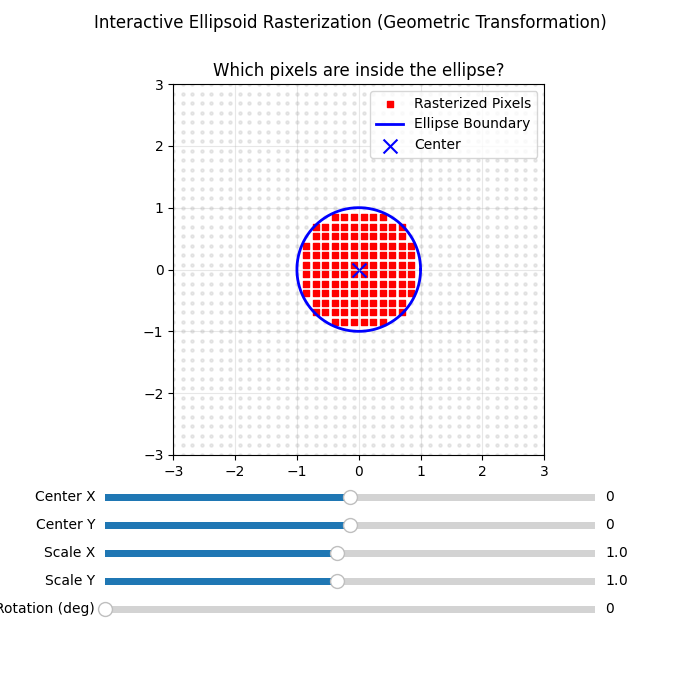

In [ ]:
%matplotlib ipympl

# Setup grid
grid_size = 40
x = np.linspace(-3, 3, grid_size)
y = np.linspace(-3, 3, grid_size)
X, Y = np.meshgrid(x, y)

# Initial ellipse parameters (geometric approach)
center_x, center_y = 0.0, 0.0
scale_x, scale_y = 1.0, 1.0
angle_deg = 0.0

fig = plt.figure(figsize=(7, 7))
fig.suptitle("Interactive Ellipsoid Rasterization (Geometric Transformation)")
plt.subplots_adjust(bottom=0.35)

ax_plot = plt.axes()
ax_plot.set_xlim(-3, 3)
ax_plot.set_ylim(-3, 3)
ax_plot.set_aspect('equal')
ax_plot.set_title("Which pixels are inside the ellipse?")
ax_plot.grid(True, alpha=0.3)

grid_outside = ax_plot.scatter([], [], c='lightgray', s=20, marker='.', alpha=0.5)
grid_inside = ax_plot.scatter([], [], c='red', s=20, marker='s', label='Rasterized Pixels')
ellipse_line, = ax_plot.plot([], [], 'b-', linewidth=2, label='Ellipse Boundary')
center_point = ax_plot.scatter([center_x], [center_y], c='blue', s=100, marker='x', label='Center')
ax_plot.legend()

def test_ellipse_geometric(X, Y, cx, cy, sx, sy, angle_rad):
    """Test if points are inside ellipse using inverse transformation.
    
    Strategy: Build transformation matrix M = T·R·S explicitly,
    compute M^-1, then check if ||M^-1·p|| <= 1
    """
    c, s = np.cos(angle_rad), np.sin(angle_rad)
    
    # Build transformation matrices explicitly
    # Scale matrix
    S = np.array([
        [sx, 0,  0],
        [0,  sy, 0],
        [0,  0,  1]
    ])
    
    # Rotation matrix
    R = np.array([
        [c, -s, 0],
        [s,  c, 0],
        [0,  0, 1]
    ])
    
    # Translation matrix
    T = np.array([
        [1, 0, cx],
        [0, 1, cy],
        [0, 0, 1]
    ])
    
    # Combined transformation: M = T·R·S 
    M = T @ R @ S
    
    # Inverse transformation: M^-1 (ellipse → unit circle)
    M_inv = np.linalg.inv(TODO) or manually build M_inv
    
    # Apply M^-1 to all points (vectorized)
    # Convert grid points to homogeneous coordinates
    ones = np.ones_like(X)
    points_h = np.stack([X, Y, ones], axis=-1)  # shape: (grid_size, grid_size, 3)
    
    # Transform all points: p_unit = M^-1 @ p
    points_unit = np.einsum('ij,klj->kli', M_inv, points_h)
    
    # Check if inside unit circle: x^2 + y^2 <= 1
    dist_sq = points_unit[..., 0]**2 + points_unit[..., 1]**2
    
    return dist_sq <= 1.0

# Create sliders
slider_cx = Slider(plt.axes([0.15, 0.28, 0.7, 0.02]), "Center X", -2, 2, valinit=center_x)
slider_cy = Slider(plt.axes([0.15, 0.24, 0.7, 0.02]), "Center Y", -2, 2, valinit=center_y)
slider_sx = Slider(plt.axes([0.15, 0.20, 0.7, 0.02]), "Scale X", 0.1, 2.0, valinit=scale_x)
slider_sy = Slider(plt.axes([0.15, 0.16, 0.7, 0.02]), "Scale Y", 0.1, 2.0, valinit=scale_y)
slider_angle = Slider(plt.axes([0.15, 0.12, 0.7, 0.02]), "Rotation (deg)", 0, 360, valinit=angle_deg)

def update(val):
    cx = slider_cx.val
    cy = slider_cy.val
    sx = slider_sx.val
    sy = slider_sy.val
    angle_deg = slider_angle.val
    angle_rad = np.radians(angle_deg)
    
    # Test each pixel
    mask = test_ellipse_geometric(X, Y, cx, cy, sx, sy, angle_rad)
    
    # Update plot
    grid_outside.set_offsets(np.c_[X[~mask].ravel(), Y[~mask].ravel()])
    grid_inside.set_offsets(np.c_[X[mask].ravel(), Y[mask].ravel()])
    
    # Update center point
    center_point.set_offsets([cx, cy])
    
    # Draw ellipse boundary by transforming unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    # Unit circle
    circle_x = np.cos(theta)
    circle_y = np.sin(theta)
    
    # Apply transformation: M = T * R * S
    c, s = np.cos(angle_rad), np.sin(angle_rad)
    
    # 1. Scale
    scaled_x = circle_x * sx
    scaled_y = circle_y * sy
    
    # 2. Rotate
    rotated_x = c * scaled_x - s * scaled_y
    rotated_y = s * scaled_x + c * scaled_y
    
    # 3. Translate
    ellipse_x = rotated_x + cx
    ellipse_y = rotated_y + cy
    
    ellipse_line.set_data(ellipse_x, ellipse_y)
    
    fig.canvas.draw_idle()

slider_cx.on_changed(update)
slider_cy.on_changed(update)
slider_sx.on_changed(update)
slider_sy.on_changed(update)
slider_angle.on_changed(update)

update(None)  # Initial draw

plt.show()

## 더 알아보기

[How 3D Graphics Work](https://www.youtube.com/watch?v=C8YtdC8mxTU)

[How does Ray Tracing Work in Video Games and Movies?](https://www.youtube.com/watch?v=iOlehM5kNSk)

[Computer Graphics (CMU 15-462/662)](https://youtu.be/PhxV_JrXeVk?si=08E8rEnjh83XfZVI)

[3Blue1Brown - Linear Algebra](https://www.youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab)

[Ray Tracing Essentials Part 2: Rasterization versus Ray Tracing](https://www.youtube.com/watch?v=ynCxnR1i0QY)

[How do Graphics Cards Work? Exploring GPU Architecture](https://youtu.be/h9Z4oGN89MU?si=KZJZfrTixhbdXjZT)

[How Real Time Computer Graphics and Rasterization work](https://www.youtube.com/watch?v=brDJVEPOeY8)

[Math for Game Developers: Why do we use 4x4 Matrices in 3D Graphics?](https://www.youtube.com/watch?v=Do_vEjd6gF0)

[Quick Understanding of Homogeneous Coordinates for Computer Graphics](https://www.youtube.com/watch?v=o-xwmTODTUI)